In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 23.6 MB/s 
     |████████████████████████████████| 7.6 MB 57.3 MB/s 
     |████████████████████████████████| 182 kB 76.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#Preprocessing Data

Importing Data

In [ ]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Sentiment Analysis/train.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/Sentiment Analysis/test.csv")

In [ ]:
frames = [df1, df2]
data = pd.concat(frames)

In [ ]:
data.shape

(10000, 4)

In [ ]:
pre_trained_bert_model = 'bert-base-cased'
#bert with 12 encoder transformers(base) and giving importance to casing(cased)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_bert_model)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Getting max length sentence

In [ ]:
max_length = -1
for sen in data.text:
  length = len(tokenizer.encode(sen))
  max_length = max(max_length,length)

In [ ]:
max_length

128

Analysis of data

In [ ]:
data.head()

,text,label_sexist,label_category,label_vector
0,"Who does Jenner think she is, Hillary Clinton?...",not sexist,none,none
1,these women were pretty dumb to think a big ri...,not sexist,none,none
2,This. Also with the girls who have the potenti...,not sexist,none,none
3,We actually agree to a point. The problem is t...,not sexist,none,none
4,Plenty of women so it's still a minority.,not sexist,none,none


No missing value

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            10000 non-null  object
 1   label_sexist    10000 non-null  object
 2   label_category  10000 non-null  object
 3   label_vector    10000 non-null  object
dtypes: object(4)
memory usage: 390.6+ KB


Label Encoding of sexist/not-sexist</br>
not sexist - 0</br>
sexist - 1

In [ ]:
le = LabelEncoder()
data['tag'] = le.fit_transform(data['label_sexist'])

In [ ]:
data.head()

,text,label_sexist,label_category,label_vector,tag
0,"Who does Jenner think she is, Hillary Clinton?...",not sexist,none,none,0
1,these women were pretty dumb to think a big ri...,not sexist,none,none,0
2,This. Also with the girls who have the potenti...,not sexist,none,none,0
3,We actually agree to a point. The problem is t...,not sexist,none,none,0
4,Plenty of women so it's still a minority.,not sexist,none,none,0


<h1>Sexist/Not Sexist classification is done from now on</h1>

Checking if dataset is balanced or im-balanced

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


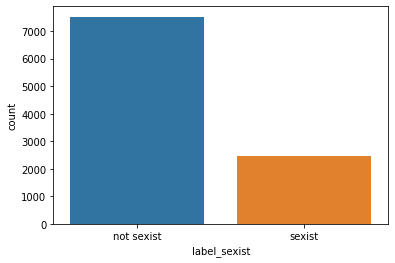

In [ ]:
sns.countplot(data['label_sexist'])

Dataset is highly imbalanced</br>
Making the dataset balanced by using RandomUnderSampler

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
X,y = data['text'],data['tag']
X,y = pd.DataFrame(X),pd.DataFrame(y)

In [ ]:
X,y = undersample.fit_resample(X,y)

In [ ]:
used_data = pd.DataFrame()
used_data['comment'] = X
used_data['tag'] = y

In [ ]:
print(used_data)

                                                comment  tag
0     [USER] I never involved my parents in my shana...    0
1     Blonde white nationalist females make me want ...    0
2     Not just her but all the other liberals in the...    0
3     Don't get me wrong - It's more likely a white ...    0
4     [USER] Myself, as well. However, in today's wo...    0
...                                                 ...  ...
4953  Okay with how things are going if ww3 happens ...    1
4954  [USER] Don't boycott all American women. Just ...    1
4955  Yeah. And I hang out in here to pass that on t...    1
4956  LOL! Well not like that. I think men should ha...    1
4957  Haha. The more men she was with prior to marri...    1

[4958 rows x 2 columns]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


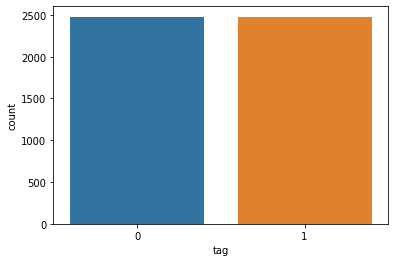

In [ ]:
sns.countplot(used_data['tag'])

We have Special Tokens </br>
Seperator tokens ('[SEP]', 102)</br>
Classification tokens ('[CLS]', 101)</br>
Padding tokens ('[PAD]', 0)</br>
Unclassified tokens ('[UNK]', 100)</br>

This is the max_length of sentence with special tokens in the system so we will set the max length to 160

In [ ]:
MAX_LENGTH = 160

Creating Pytorch dataset 

In [ ]:
class SentimentDataset(Dataset):
  def __init__(self,comments,targets,tokenizer,max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comments)

  def __getitem__(self,item):

    comment = str(self.comments[item])
    target = self.targets[item]

    #now before returning the data we will enocode it 
    encoding = self.tokenizer.encode_plus(
        comment,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids=False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
    )

    return {
        'comment' : comment,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'target' : torch.tensor(target ,dtype = torch.long)
    }


In [ ]:
def create_loader(data,tokenizer,max_len,batch_size):
  comments = data.comment.to_numpy()
  targets = data.tag.to_numpy()
  dataset = SentimentDataset(comments,targets,tokenizer,max_len)
  dataloader = DataLoader(dataset,batch_size = batch_size,num_workers = 2)
  return dataloader

Spitting dataset

In [ ]:
RANDOM_SEED = 42
train_data, val_data = train_test_split(used_data, test_size=0.2, random_state=RANDOM_SEED)
test_data, val_data = train_test_split(val_data, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
batch_size = 16
train_loader = create_loader(train_data,tokenizer,MAX_LENGTH,batch_size)
val_loader = create_loader(val_data,tokenizer,MAX_LENGTH,batch_size)
test_loader = create_loader(test_data,tokenizer,MAX_LENGTH,batch_size)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(3966, 2)
(496, 2)
(496, 2)


Example of our dataset

In [ ]:
temp_data = next(iter(train_loader))

In [ ]:
print(len(temp_data['comment']))
print(temp_data['input_ids'].shape)
print(temp_data['target'].shape)
print(temp_data['attention_mask'].shape)

16
torch.Size([16, 160])
torch.Size([16])
torch.Size([16, 160])


In [ ]:
print(temp_data['comment'][0])
print(temp_data['input_ids'][0])
print(temp_data['target'][0])
print(temp_data['attention_mask'][0])

When your being questioned on the street by a Bobby Hijabi.....
tensor([ 101, 1332, 1240, 1217, 8449, 1113, 1103, 2472, 1118,  170, 5545, 8790,
        3174, 5567,  119,  119,  119,  119,  119,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 

#Bert Model for text classification 

Bert model return last state of hidden layer and pooled_output </br>
The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state.</br>
BertPoolear applies activation function on the last_hidden_state first element which is CLS and then applies activation function 'tanh'</br>



In [ ]:
pre_trained_bert_model = 'bert-base-cased'

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self,n_classes):
    super(SentimentClassifier,self).__init__()
    self.dropout = nn.Dropout(p=0.3)
    self.bert = BertModel.from_pretrained(pre_trained_bert_model)
    self.linear = nn.Linear(self.bert.config.hidden_size,n_classes)

  def forward(self,input_ids,attention_mask):
    _ , pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict = False
    )
    out = pooled_output
    out = self.dropout(out)
    out = self.linear(out)
    return out


In [ ]:
model = SentimentClassifier(2)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Example

In [ ]:
# temp_data = next(iter(train_loader))

In [ ]:
# input_ids = temp_data['input_ids']
# attention_mask = temp_data['attention_mask']
# comment = temp_data['comment']

In [ ]:
# print(comment)
# print(input_ids.shape)
# print(attention_mask.shape)
#so our model needs a tensor as input having batch_size number of elements

In [ ]:
# output = model(input_ids,attention_mask)

In [ ]:
# print(output)

In [ ]:
# X = torch.softmax(output,dim=1)
# print(X)

In [ ]:
# X.shape

In [ ]:
# print(torch.max(X,dim=1))

[1 0] - 0/not sexist label</br>
[0 1] - 1/sexist label

#Training of model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#hyperparameters
epochs = 10
learning_rate = 2e-5
total_steps = len(train_loader) * epochs

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, n_examples):
  model = model.train().to(device)
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["target"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, n_examples):
  model = model.eval().to(device)

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["target"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
for epoch in range(epochs):

  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_loader,    
    loss_fn, 
    optimizer, 
    scheduler, 
    len(train_data)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_loader,
    loss_fn, 
    len(val_data)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  

Saving Model

In [ ]:
model_save_name = 'sentimentClassifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

#Testing

Load Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
model_save_name = 'sentimentClassifier.pt'
path = F"/content/gdrive/MyDrive/Sentiment Analysis/sentimentClassifier.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def evaluate_model(model, data_loader, loss_fn, n_examples):
  model = model.eval().to(device)

  losses = []
  correct_predictions = 0
  prediction = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["target"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      prediction.extend(preds)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  prediction = torch.stack(prediction).cpu()
  return prediction,correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
y_pred, test_acc, _ = evaluate_model(
    model,
    test_loader,    
    loss_fn, 
    len(test_data)
  )
print(f'Testing accuracy is {test_acc}')

Testing accuracy is 0.842741935483871


We need to print the Classification report and the Confusion Matrix

In [ ]:
y_test = torch.Tensor(test_data['tag'].tolist())

In [ ]:
class_names=['not-sexist','sexist']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  not-sexist       0.82      0.87      0.84       244
      sexist       0.87      0.82      0.84       252

    accuracy                           0.84       496
   macro avg       0.84      0.84      0.84       496
weighted avg       0.84      0.84      0.84       496



In [ ]:
sum(test_data['tag'])
#1-sexist
#0-not sexist

252

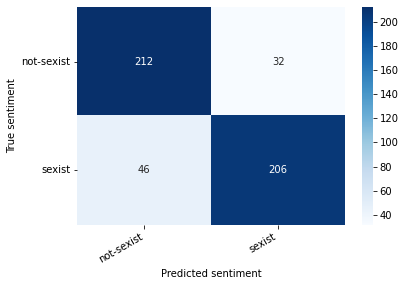

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

We can see the model performs well on both sexist and not sexist data

Now to check our model on all dataset

In [ ]:
X,y = data['text'],data['tag']

In [ ]:
data = pd.DataFrame()
data['comment'] = X
data['tag'] = y

In [ ]:
data_loader = create_loader(data,tokenizer,MAX_LENGTH,batch_size)

In [ ]:
# y_pred, test_acc, _ = evaluate_model(
#     model,
#     data_loader,    
#     loss_fn, 
#     len(data)
#   )
# print(f'Testing accuracy is {test_acc}')

Testing accuracy is 0.8704000000000001


Overall accuracy on our whole dataset

#New Dataset

In [ ]:
review_text = "I love you"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LENGTH,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding = 'max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(
    input_ids,
    attention_mask
)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love you
Sentiment  : not-sexist


#Scraping tweets

We'll scrape tweets of username to check whether the username has been tweeting sexist comments or not

In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 6.5 MB/s 


In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [ ]:
twitter_handle = "elonmusk"
query = "(from:"+twitter_handle+") until:2022-01-01 since:2019-01-01"
tweets = []
limit = 500

In [ ]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
     
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

<ipython-input-70-072abb801063>:8: FutureWarning: username is deprecated, use user.username instead
  tweets.append([tweet.date, tweet.username, tweet.content])


In [ ]:
df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
print(df['Tweet'][49])

@BLKMDL3 Good idea


In [ ]:
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocessingData(temp_data):
  # we need a training corpus
  all_sentences = []

  tweet = temp_data[2]
  for date,user,tweet in temp_data:
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)#removing mentions
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)#removing hashtag
    clean_tweet = deEmojify(clean_tweet)
    all_sentences.append(clean_tweet)
  return all_sentences

In [ ]:
data = preprocessingData(df.to_numpy())

In [ ]:
total_sexist_comments = 0
sexist_comments = []
for tweet in data:
  encoded_review = tokenizer.encode_plus(
    tweet,
    max_length=MAX_LENGTH,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding = 'max_length',
    return_attention_mask=True,
    return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(
      input_ids,
      attention_mask
  )
  _, prediction = torch.max(output, dim=1)
  if prediction==1:
    sexist_comments.append(tweet)
  total_sexist_comments +=prediction


In [ ]:
print(f'Total Sexist comments in past 2 years for {twitter_handle} is {total_sexist_comments.item()}')

Total Sexist comments in past 2 years for elonmusk is 5


In [ ]:
sexist_comments

['  Useful mass to orbit is what matters',
 '   Sneaky, but ineffective, like the rest of what she does 🤣🤣',
 ' Real androids are coming',
 ' Lasers can do anything',
 ' But lower power density than a human']

In [ ]:
#LOL
#END